# 2th Technical Meeting - Unet Tutorial

This material is part of 2th Technical Meeting of NexGenMap project  [(event website)](https://sites.google.com/view/nextgenmap2reuniao/página-inicial).

The NexGenMap is a project that aims establish the next generation of land use and land cover mapping and monitoring tools, using high-res images (i.e. Planet data), cloud-computing platforms (i.e. Google Earth Engine and Google Cloud Computing) and machine learning and deep-learning techniques (e.g. Random Forest, U-Net and LSTM).

The main goal of this tutorial is run a semantic segmentation deep-learning approach, through U-net, to identify cattle drinking fountains using monthly Planet mosaics of NexGenMap. It's organized:
* Data and Libraries
* Data Exploration and Normalization
* U-net model (train/validation/prediction)

## Data and Libraries

All routines that will be used are in the module [nexutil](nexutil.py) and in the repository [dl-semantic-segmentation](https://github.com/NexGenMap/dl-semantic-segmentation). They have follow dependencies:
* [Gdal](https://pypi.org/project/GDAL/): manipulating geospatial raster data;
* [Numpy](http://www.numpy.org/): image computing;
* [Tensorflow](https://www.tensorflow.org/): deep-learning implementation;
* [Scikit-learn](http://scikit-learn.org): machine-learning support;
* [Scikit-image](http://scikit-image.org/): image histogram equalization;
* [Matplotlib](https://matplotlib.org/): image and chart visualization;
* [Seaborn](https://seaborn.pydata.org/): confusion matrix visualization;
* [Psutil](https://psutil.readthedocs.io/en/latest/): python system and process utilities
* [Rios](https://bitbucket.org/chchrsc/rios/overview): raster I/O Simplification

Please install them using an specific OS commands or PIP:

In [ ]:
%%bash
pip3 install --user numpy
pip3 install --user tensorflow-gpu==1.7.0 
pip3 install --user scikit-image
pip3 install --user scikit-learn 
pip3 install --user matplotlib 
pip3 install --user seaborn
pip3 install --user psutil
pip3 install --user download https://bitbucket.org/chchrsc/rios/downloads/rios-1.4.5.tar.gz

Import the [nexutil](nexutil.py) module

In [1]:
import nexutil

...and now the repository [dl-semantic-segmentation](https://github.com/NexGenMap/dl-semantic-segmentation).

In [2]:
file_url = 'https://github.com/NexGenMap/dl-semantic-segmentation/archive/master.zip'
filename = 'master.zip'

#nexutil.download_extract_zipfile(file_url, filename)
nexutil.import_repository('dl-semantic-segmentation-master/src/')

We will work with 2 files (SD-22-Z-C-alfa_2-1.tif, SD-22-Z-C-alfa_2-2.tif), with 30 km2 each, derived from monthly mosaic of NexGenMap:
<img src="figs/02-2th_Technical_Meeting_U-net/01-study_area.png">

In [ ]:
file_url = 'https://www.lapig.iesa.ufg.br/lapig/nextgenmap-data/tutorial-sessions/02-2th_Technical_Meeting_U-net/input_images.zip'
filename = 'input_images.zip'

nexutil.download_extract_zipfile(file_url, filename)
nexutil.import_repository('dl-semantic-segmentation-master/src/')

## Data Exploration and Normalization

Lets check those two files:

In [ ]:
nexutil.image_info('input_images/SD-22-Z-C-alfa_2-1.tif')

In [ ]:
nexutil.image_info('input_images/SD-22-Z-C-alfa_2-2.tif')

Let's go visualization !

Image from 11/2017:

In [ ]:
nexutil.vis_image('input_images/SD-22-Z-C-alfa_2-1.tif', bands=[1,2,3])

Image is from 03/2018:

In [ ]:
nexutil.vis_image('input_images/SD-22-Z-C-alfa_2-1.tif', bands=[5,6,7])

Reference data for cattle drinking fountains:

In [ ]:
nexutil.vis_image('input_images/SD-22-Z-C-alfa_2-1.tif', bands=[8])

Let's calculate the basic statistics:

In [ ]:
images = [
    'input_images/SD-22-Z-C-alfa_2-1.tif',
    'input_images/SD-22-Z-C-alfa_2-2.tif'
]
nexutil.stats_from_files(images,-10.0)

Those images was normalized using [normalize_image.py](https://github.com/NexGenMap/dl-semantic-segmentation/blob/master/src/normalization/normalize_image.py) and the mathematical formula [(pixel_value - median) / stdDev]. It was performed using the follow command (to understand more about this subject [click here](http://localhost:8888/notebooks/01-EEUS2018_NexGenMap.ipynb#Standardizing))

## U-net model
The module run is the main module of repository [dl-semantic-segmentation](https://github.com/NexGenMap/dl-semantic-segmentation). Let's import it.

In [3]:
import run

Our U-net implementation has the follow parameters:
* Input data:
    * **n_classes**: number of classes of the reference data *[default value = 2]*
    * **n_input_bands**: number of bands of the input raster file *[default value = 9]*
    * **nodata_value**: nodata value of the input raster file *[default value = -10]*
* Data augmentation:
    * **chip_offsets**: offset, in percentage, of start position of chip generation approach *[default value = [(0,0), (50,50)]]*
	* **chip_rotate**: rotate the chip considering the angles 90°, 180°, and 270° degrees *[default value = False]*
	* **chip_flip**: flip the orders of input raster bands *[default value = True]*
* Train:
    * **model_dir**: directory that will maintain the trained model and the Tensorboard logs *[default value = 'logs_bebedouros']*
    * **seed**: seed that will be used in all random methods *[default value = 1989]*
    * **pad_size**: pad size of output chip in relation to the input chip *[default value = 93]*
    * **chip_size**: size of the output chip *[default value = 100]*
    * **batch_size**: batch size of train *[default value = 32]*
    * **num_epochs**: number of epochs of train *[default value = 200]*
    * **dropout_rate**: dropout rate of before output layer *[default value = 0.5]*
    * **learning_rate**: learning rate of train *[default value = 0.00001]*
    * **tensorboard_maxoutput**: number of images that will show in the Tensorboard *[default value = 2]*
    * **l2_regularizer**: L2 regularizer rate of all convolutional layers *[default value = 0.5]*

Let's check them:

In [ ]:
print(run.params)

Let's train only 1 epoch:

In [ ]:
img_input_path = 'input_images/SD-22-Z-C-alfa_2-1.tif'
run.params['num_epochs'] = 1

# Disable data augmentation if you don't have GPU
run.params['chip_offsets'] = [(0,0)]
run.params['chip_rotate'] = False
run.params['chip_flip'] = False

run.train(img_input_path, run.params)

Let's evaluate the classification performance with test dataset (to understand more about this subject [click here](http://localhost:8888/notebooks/01-EEUS2018_NexGenMap.ipynb#Evaluate)):

In [ ]:
run.evaluate(img_input_path, run.params)

In general, training a U-NET, or any other neural network, takes time. To avoid this "boring" task you can use a pre-trained model, that was trained with data augmentation result, in a multi-GPU server, for almost 10 hour.

In [ ]:
file_url = 'https://www.lapig.iesa.ufg.br/lapig/nextgenmap-data/tutorial-sessions/02-2th_Technical_Meeting_U-net/trained_model_200e.zip'
filename = 'trained_model_200e.zip'

nexutil.download_extract_zipfile(file_url, filename)

Let's evaluate again:

In [4]:
img_input_path = 'input_images/SD-22-Z-C-alfa_2-1.tif'
run.params['model_dir'] = 'trained_model_200e'
run.evaluate(img_input_path, run.params)

After check the classification metrics, and get good results, you will predict all the image. It will permit evaluate the spatial consistency of output.

In [9]:
img_input_path = 'input_images/SD-22-Z-C-alfa_2-2.tif'
img_output_path = 'input_images/SD-22-Z-C-alfa_2-2_predict.tif'

run.predict(img_input_path, run.params, img_output_path)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'trained_model_200e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f256ee5ab00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Predicting image input_images/SD-22-Z-C-alfa_2-2.tif 0.9940828402366864%
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_model_200e/model.ckpt-50310
INFO:tensorflow:Running local_i

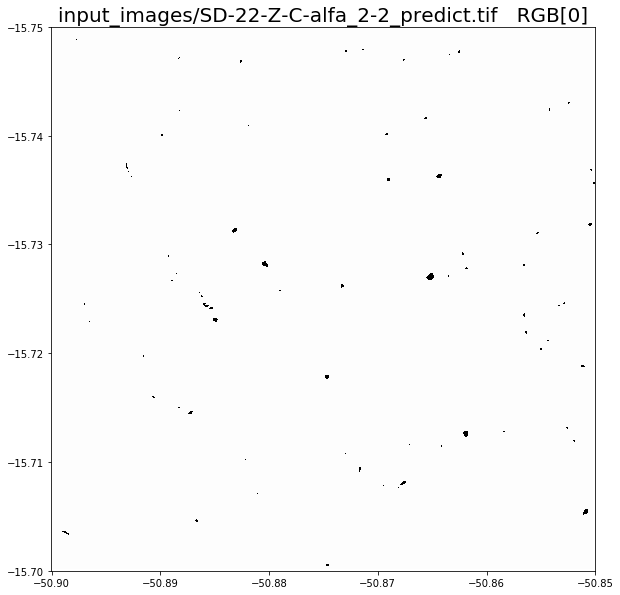

In [10]:
nexutil.vis_image('input_images/SD-22-Z-C-alfa_2-2_predict.tif', bands=[0])

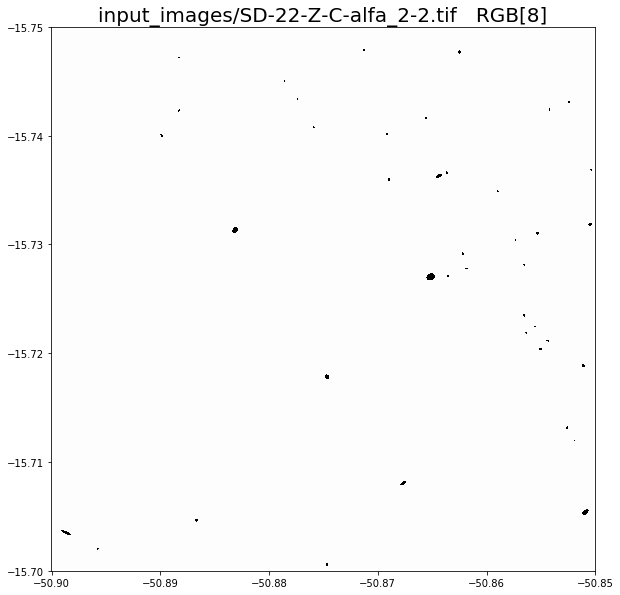

In [11]:
nexutil.vis_image('input_images/SD-22-Z-C-alfa_2-2.tif', bands=[8])